In [1]:
import cv2
import os
import numpy as np
from PIL import Image
import random

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import  preprocess_input 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter
from tensorflow.keras.models import Model
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input,BatchNormalization,Conv2D,MaxPooling2D
from keras.applications import MobileNet
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense
print("Loaded all libraries")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loaded all libraries


In [2]:
fpath = "/kaggle/input/knee-osteoarthritis-dataset-with-severity"
random_seed = 42

categories = os.listdir(fpath)
categories = categories[:20]
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['auto_test', 'val', 'test', 'train'] 

No. of categories =  4


In [3]:
train_dir = os.path.join(fpath,'train')
val_dir = os.path.join(fpath,'val')
test_dir = os.path.join(fpath, 'test')

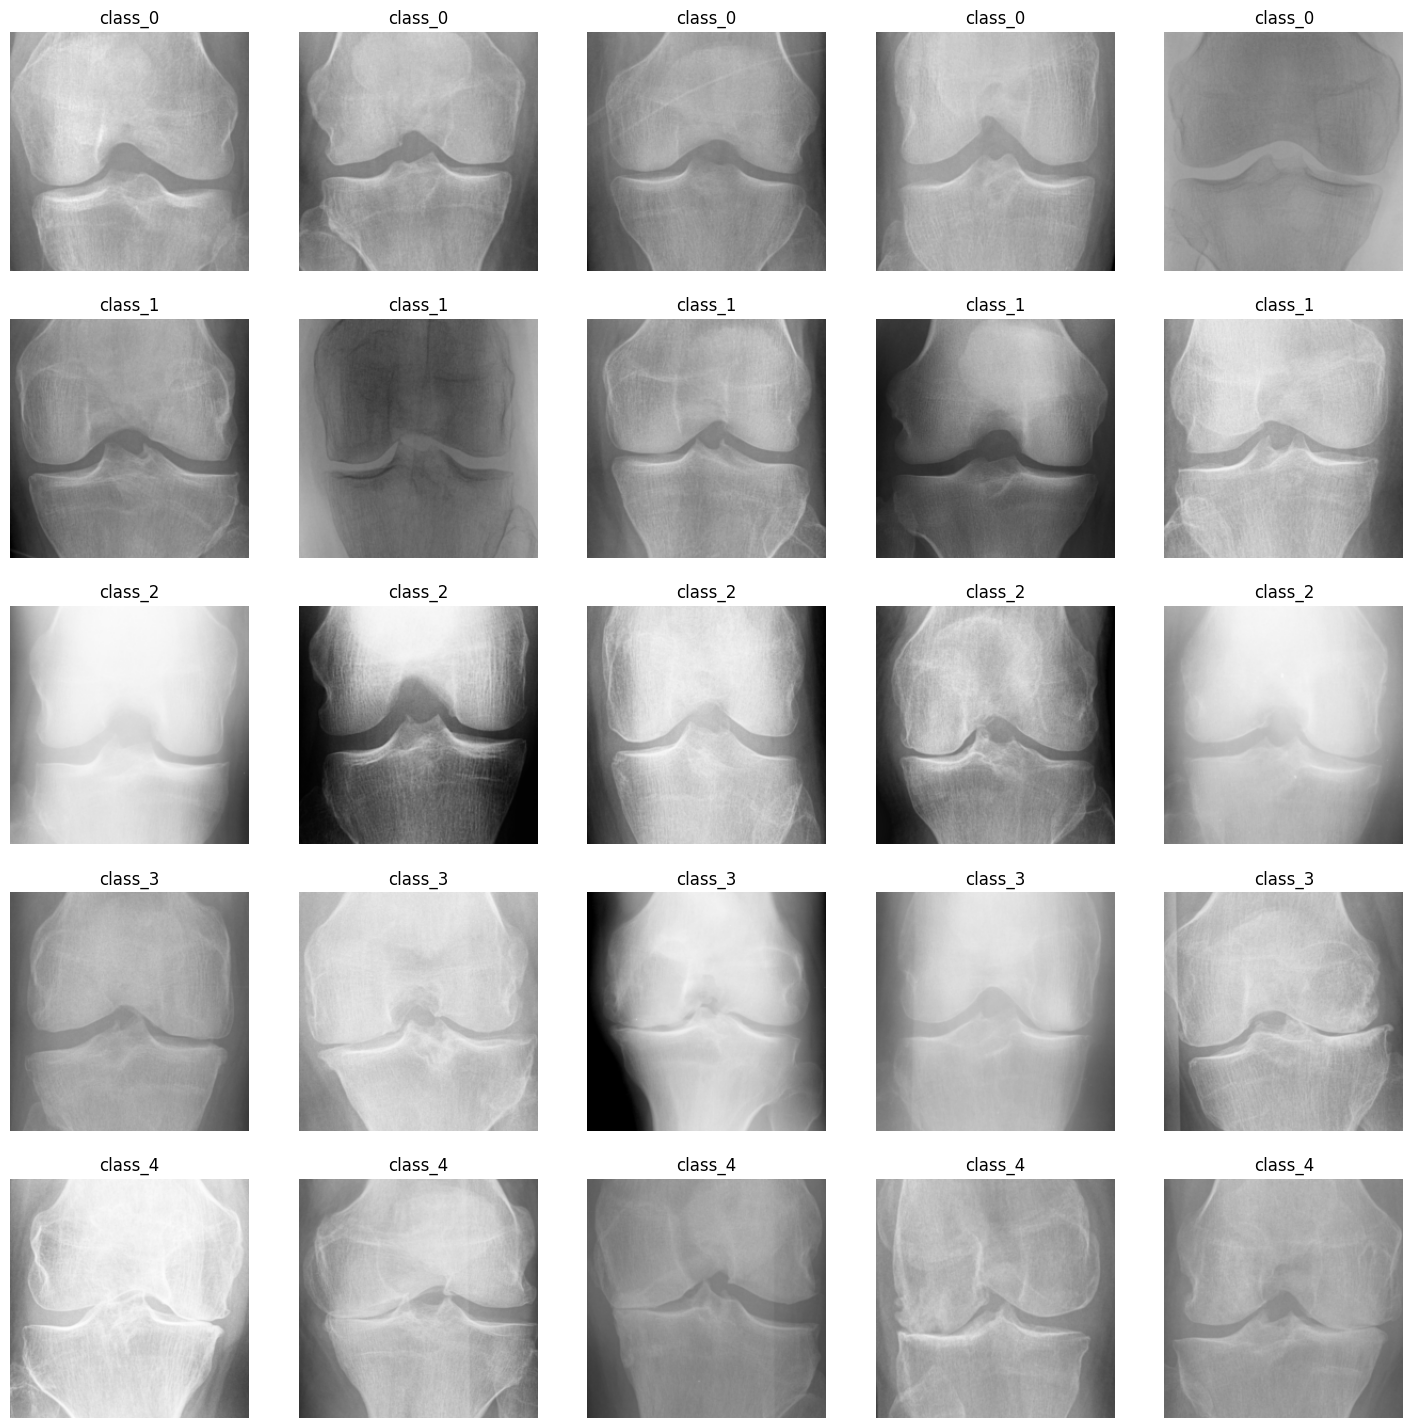

In [4]:
fig, ax = plt.subplots(5,5, figsize=(18,18))

for class_id in range(5):
    folder = os.path.join(train_dir,str(class_id))
    os.chdir(folder)
    samples = random.sample(os.listdir(folder), 5)
    
    for col in range(5):
        image = cv2.imread(samples[col])
        ax[class_id, col].imshow(image)
        ax[class_id, col].set_title("class_" + str(class_id))
        ax[class_id, col].set_axis_off()
    
plt.show()

In [5]:
import os
import shutil

input_folder = train_dir
temp_output_folder = '/kaggle/working/temp'

# Create temp output folder if it doesn't exist
os.makedirs(temp_output_folder, exist_ok=True)

files_and_subfolders = os.listdir(input_folder)

for item in files_and_subfolders:
    source_path = os.path.join(input_folder, item)
    destination_path = os.path.join(temp_output_folder, item)
    
    # Check if destination folder exists before copying
    if os.path.isdir(source_path):
        if not os.path.exists(destination_path):
            shutil.copytree(source_path, destination_path)
    else:
        shutil.copy(source_path, destination_path)

print(f"Training data copied from {input_folder} to {temp_output_folder}.")

Training data copied from /kaggle/input/knee-osteoarthritis-dataset-with-severity/train to /kaggle/working/temp.


In [6]:
import os
import random

def delete_remaining_images( num_images_to_keep):
    class_folder = os.path.join(temp_output_folder, '0')
    # Get a list of all files in the class folder
    all_files = os.listdir(class_folder)
    # Select a random subset of files to keep
    files_to_keep = random.sample(all_files, num_images_to_keep)

    # Delete remaining files in the class folder
    for filename in all_files:
        file_path = os.path.join(class_folder, filename)
        # Delete the file if it's not in the selected subset
        if filename not in files_to_keep:
               os.remove(file_path)

# Delete remaining images in the same class
delete_remaining_images(1500)

In [7]:
len(os.listdir(os.path.join(temp_output_folder, '0')))

1500

In [8]:
def show_distribution(folder):
    
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_directory(folder)

    counter = Counter(generator.classes)                          
    total_images = sum(counter.values())
    distribution = [(class_id,round(num_images / total_images * 100,2)) for class_id, num_images in counter.items()]

    for class_id, percentage in distribution:
        print(class_id, percentage)

In [9]:
print("The distribution for the training data is :\n")
show_distribution(temp_output_folder)

The distribution for the training data is :

Found 4992 images belonging to 5 classes.
0 30.05
1 20.95
2 30.37
3 15.16
4 3.47


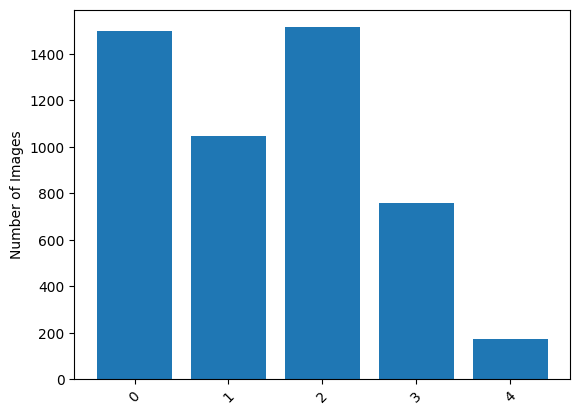

In [10]:
import matplotlib.pyplot as plt

subdirectories = sorted([os.path.join(temp_output_folder, d) for d in os.listdir(temp_output_folder) if os.path.isdir(os.path.join(temp_output_folder, d))])

# Extract only the folder names from the paths
folder_names = [os.path.basename(d) for d in subdirectories]

# Count the number of images in each subdirectory
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))

# Create a bar chart to visualize the distribution
plt.bar(folder_names, counts)
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.show()

In [11]:
folder = os.path.join(train_dir,'4')
os.chdir(folder)
samples = random.sample(os.listdir(folder), 10)

for filename in samples:
    image = cv2.imread(filename)
    print(image.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [12]:
NUM_CLASSES = 5
IMAGE_SIZE=[224, 224]
BATCH_SIZE=32

In [13]:
# Create the Generators
train_val_generator = ImageDataGenerator(
                                        preprocessing_function=preprocess_input,    
                                        rotation_range=10,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode='nearest'
                                        )


# Train data generator
train_data = train_val_generator.flow_from_directory(train_dir, 
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True
                                                    )

# Validation data generator
val_data = train_val_generator.flow_from_directory(val_dir, 
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  color_mode='rgb',
                                                   shuffle=True
                                                  )

# Test data generator
test_generator  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_generator.flow_from_directory(test_dir, 
                                               target_size=IMAGE_SIZE,
                                               batch_size=1,
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               shuffle=False
                                               )

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.


In [14]:
model=Sequential()
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
NUM_CLASSES = 5

# Adding some layers to the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # NUM_CLASSES is the number of output classes

# Creating the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding some layers to the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # NUM_CLASSES is the number of output classes

# Creating the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_1[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                   

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

hist = model.fit(train_data,
                 validation_data=val_data,
                 epochs=20,
#                  class_weight=class_weights,
                 callbacks=[reduce_lr, early_stopping],
                 verbose=1)

Epoch 1/20
181/181 [==============================] - 120s 466ms/step - loss: 1.2892 - accuracy: 0.4491 - val_loss: 1.9318 - val_accuracy: 0.1283 - lr: 0.0010
Epoch 2/20
181/181 [==============================] - 82s 451ms/step - loss: 1.0593 - accuracy: 0.5476 - val_loss: 1.5316 - val_accuracy: 0.2567 - lr: 0.0010
Epoch 3/20
181/181 [==============================] - 81s 447ms/step - loss: 0.9801 - accuracy: 0.5869 - val_loss: 1.5490 - val_accuracy: 0.2567 - lr: 0.0010
Epoch 4/20
181/181 [==============================] - 79s 436ms/step - loss: 0.9498 - accuracy: 0.5964 - val_loss: 1.6030 - val_accuracy: 0.2567 - lr: 0.0010
Epoch 5/20
181/181 [==============================] - 81s 446ms/step - loss: 0.9184 - accuracy: 0.6075 - val_loss: 1.4286 - val_accuracy: 0.3971 - lr: 0.0010
Epoch 6/20
181/181 [==============================] - 80s 444ms/step - loss: 0.9066 - accuracy: 0.6090 - val_loss: 1.4250 - val_accuracy: 0.4044 - lr: 0.0010
Epoch 7/20
181/181 [==============================]

In [17]:
model.evaluate(test_data)


1656/1656 [==============================] - 16s 10ms/step - loss: 1.4401 - accuracy: 0.4058


[1.4401336908340454, 0.4057970941066742]